### Importing Libraries and Early Data Exploration

In [1]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support  
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images = np.load('/content/drive/My Drive/AIML/Project 8/images.npy')
data = pd.read_csv('/content/drive/My Drive/AIML/Project 8/Labels.csv')
df = data.copy()

In [4]:
df.shape

(4750, 1)

- 4750 images in the data

In [5]:
df.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

- 3 highest classes of images are Loose Silky-bent, Common Chickweed and Scentless Mayweed

### EDA

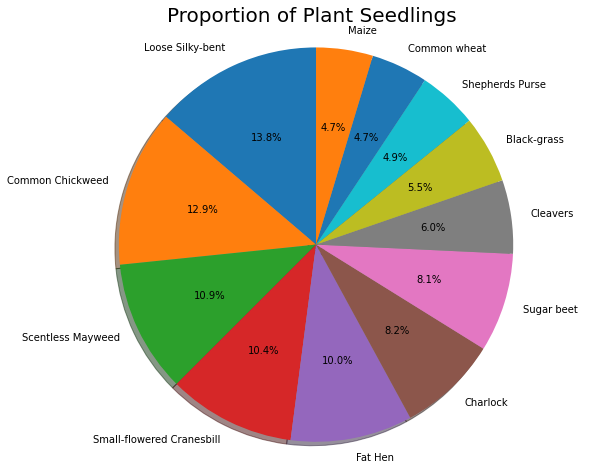

In [6]:
labels = df['Label'].value_counts().index.tolist()
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(data = df, x= df.value_counts(), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Plant Seedlings ", size = 20)
plt.show()

- reinforcing top 3 and their percentages

In [7]:
df.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


- peak into the data

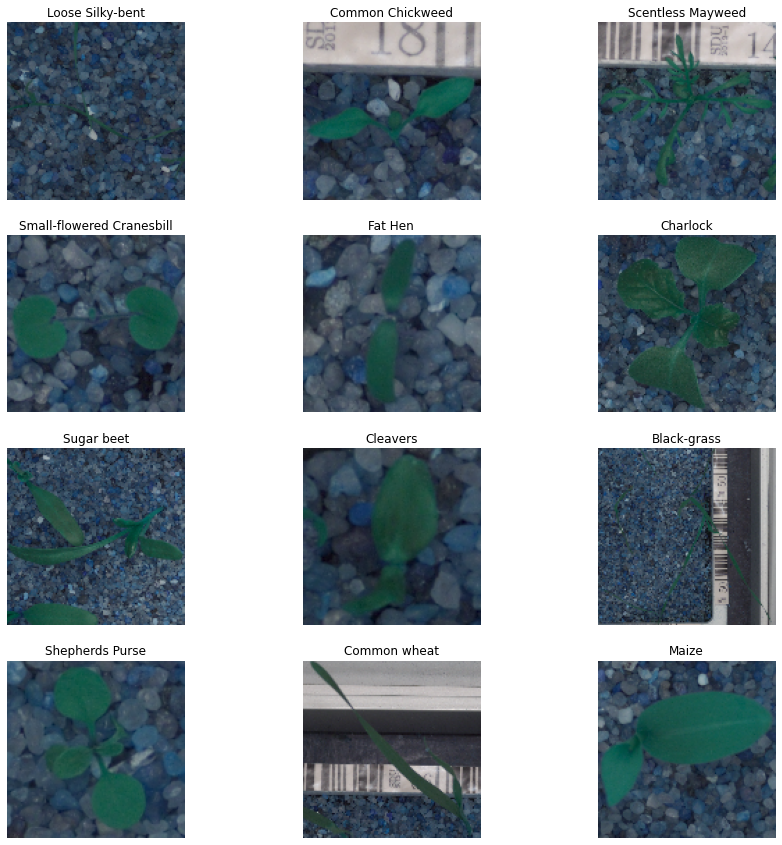

In [8]:
fig = plt.figure(figsize = (15,15))
i=0
for label in labels:
  index = df[df['Label']==label].first_valid_index();
  ax = fig.add_subplot(4, 3, i+1);
  plt.imshow(images[index], cmap='Greys_r');
  plt.title(label);
  plt.axis('off');
  i=i+1;
plt.show();

- First image in the data with each classification
- Common wheat and black greass have sticks in the shape/colour of barcodes could affect CNN gradients

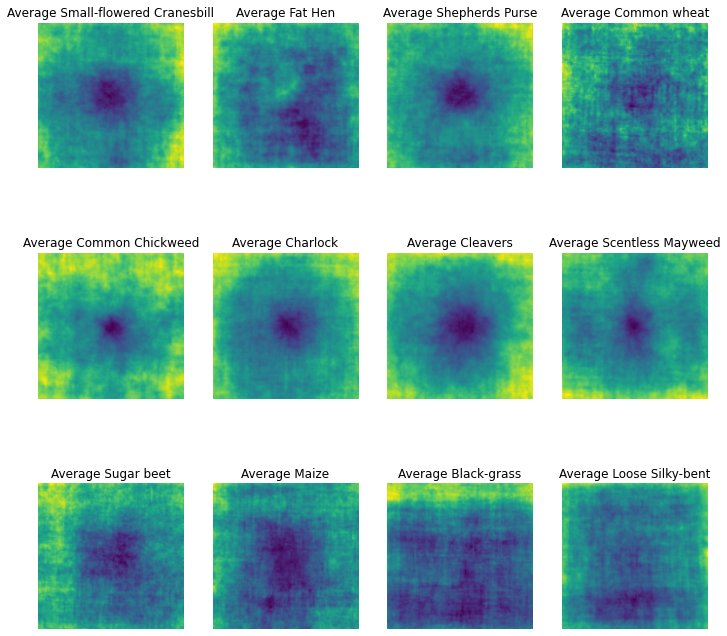

In [11]:
def find_mean_img(full_mat):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((150,150))
  
    return mean_img

CATEGORIES = df['Label'].unique()
d = { i:[] for i in CATEGORIES}

for i in df.index:
    gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray,(150,150))
    d[df['Label'][i]].append(gray)

l = []
for i in d.keys():
  l.append(find_mean_img(d[i]))

plt.subplots(figsize=(12,12))
for i in range(len(l)):
    plt.subplot(3,4,i + 1,title='Average '+list(d.keys())[i])
    plt.imshow(l[i])
    plt.axis('off')

- All mean images came out in various shades of gray

### Gaussian Blurring Preprocessing and HSV Conversion

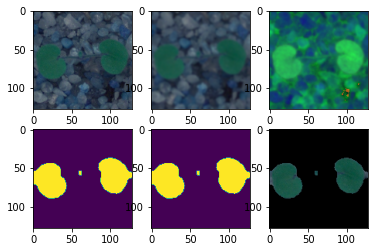

# CLEANED IMAGES


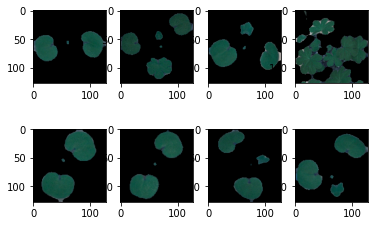

In [17]:
new_train = []
sets = []; getEx = True
for i in images:
  blurr = cv2.GaussianBlur(i,(5,5),0)
  hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
#HSV Bou daries for the Green color (GREEN PARAMETERS)
  lower = (25,40,50)
  upper = (75,255,255)
  mask = cv2.inRange(hsv,lower,upper) # create a mask 
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) #getting structring element ( kernal) of sie 11x11
  mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # applying morphological transformation ( closing operation ) to remove imperfections from the binary image ( mask)
  boolean = mask>0
  new = np.zeros_like(i,np.uint8)
  new[boolean] = i[boolean]
  new_train.append(new)
  if getEx:
      plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
      plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
      plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
      plt.subplot(2,3,4);plt.imshow(mask) # MASKED
      plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
      plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
      plt.show()
      getEx = False
new_train = np.asarray(new_train)
print("# CLEANED IMAGES")
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

In [ ]:
#normalize the data
new_train = new_train/255

### Train Test Split

In [18]:
x = new_train
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(df)

In [19]:
print(y.shape)
print(x.shape)

(4750, 12)
(4750, 128, 128, 3)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(x,y , test_size=0.3, random_state=0,stratify=y)


In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(1425, 128, 128, 3)
(1425, 12)


- Train and test shapes for X and Y variables

In [22]:
#checking class distribution after stratify
pd.DataFrame(y_train.argmax(axis=1)).value_counts()/pd.DataFrame(y_train.argmax(axis=1)).value_counts().sum()


6     0.137744
3     0.128722
8     0.108571
10    0.104361
5     0.099850
1     0.082105
11    0.080902
2     0.060451
0     0.055338
9     0.048722
4     0.046617
7     0.046617
dtype: float64

In [23]:
pd.DataFrame(y_test.argmax(axis=1)).value_counts()/pd.DataFrame(y_test.argmax(axis=1)).value_counts().sum()


6     0.137544
3     0.128421
8     0.108772
10    0.104561
5     0.100351
1     0.082105
11    0.081404
2     0.060351
0     0.055439
9     0.048421
4     0.046316
7     0.046316
dtype: float64

### Model Building - Model 1

In [46]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D

batch_size=None
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dense(12, activation="softmax"))

In [47]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
history = model.fit( x=X_train, y=y_train, batch_size=32, epochs=50, validation_split = 0.3)

Epoch 1/50
66/66 [==============================] - 6s 81ms/step - loss: 2.7663 - accuracy: 0.1313 - val_loss: 2.3701 - val_accuracy: 0.1771
Epoch 2/50
66/66 [==============================] - 4s 60ms/step - loss: 2.1424 - accuracy: 0.2727 - val_loss: 1.9316 - val_accuracy: 0.3608
Epoch 3/50
66/66 [==============================] - 4s 63ms/step - loss: 1.7089 - accuracy: 0.4274 - val_loss: 1.5590 - val_accuracy: 0.4766
Epoch 4/50
66/66 [==============================] - 4s 64ms/step - loss: 1.3779 - accuracy: 0.5330 - val_loss: 1.4118 - val_accuracy: 0.5234
Epoch 5/50
66/66 [==============================] - 4s 65ms/step - loss: 1.1252 - accuracy: 0.6151 - val_loss: 1.2008 - val_accuracy: 0.5857
Epoch 6/50
66/66 [==============================] - 4s 63ms/step - loss: 0.9488 - accuracy: 0.6643 - val_loss: 1.0914 - val_accuracy: 0.6136
Epoch 7/50
66/66 [==============================] - 4s 61ms/step - loss: 0.8085 - accuracy: 0.7163 - val_loss: 1.1549 - val_accuracy: 0.6058
Epoch 8/50
66

- val_loss increased through iterations, model improved accuracy significantly by final epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


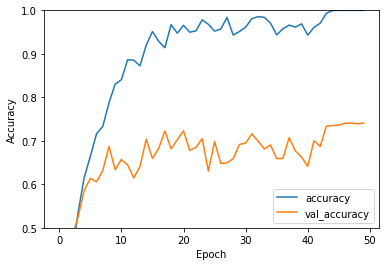

In [48]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

- Model starts to overfit  after the 15th epoch, val accuracy  is approximately constant by the  20th epoch.

In [49]:
score = model.evaluate(X_test,y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4859373569488525
Test accuracy: 0.7431579232215881


-  Accuracy is on the lower end, model is overfit to training data, while validation accuracy changes throughout, looking overtime there is no major increase throughout testing, test accuracy confirms this




#### How to prevent overfitting?
- Adding dropouts to model
-data augmentation
-batch normalization

### Model Building - Model 2

In [50]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

- using ReduceLRonPlateau to decrease learning rate

#### Data Augmentation

In [51]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [52]:
# creating validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.1, random_state=0,stratify=y_train)

In [53]:
X_train.shape

(2692, 128, 128, 3)

In [55]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(128, 128, 3)))
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation="relu"))
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model2.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.4))
model2.add(GlobalMaxPooling2D())
model2.add(Dense(256, activation="relu"))
model2.add(Dense(12, activation="softmax"))

model2.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])
batch_size = 38
history_model_ln2 = model2.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 1/30
70/70 - 31s - loss: 2.9404 - accuracy: 0.1115 - val_loss: 2.4215 - val_accuracy: 0.2400 - lr: 0.0010 - 31s/epoch - 442ms/step
Epoch 2/30
70/70 - 11s - loss: 2.2587 - accuracy: 0.2291 - val_loss: 2.1316 - val_accuracy: 0.2500 - lr: 0.0010 - 11s/epoch - 155ms/step
Epoch 3/30
70/70 - 11s - loss: 2.0257 - accuracy: 0.2611 - val_loss: 2.0595 - val_accuracy: 0.2600 - lr: 0.0010 - 11s/epoch - 162ms/step
Epoch 4/30
70/70 - 11s - loss: 1.8139 - accuracy: 0.3372 - val_loss: 1.8144 - val_accuracy: 0.3367 - lr: 0.0010 - 11s/epoch - 152ms/step
Epoch 5/30
70/70 - 12s - loss: 1.6787 - accuracy: 0.3836 - val_loss: 1.6621 - val_accuracy: 0.4067 - lr: 0.0010 - 12s/epoch - 175ms/step
Epoch 6/30
70/70 - 11s - loss: 1.5580 - accuracy: 0.4326 - val_loss: 1.5611 - val_accuracy: 0.4667 - lr: 0.0010 - 11s/epoch - 150ms/step
Epoch 7/30
70/70 - 11s - loss: 1.4796 - accuracy: 0.4552 - val_loss: 1.5576 - val_accuracy: 0.4700 - lr: 0.0010 - 11s/epoch - 151ms/step
Epoch 8/30
70/70 - 11s - loss: 1.4006 - a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


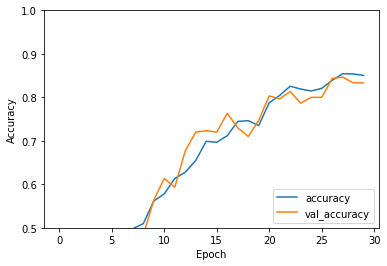

In [56]:
print(history_model_ln2.history.keys())
# summarize history for accuracy
plt.plot(history_model_ln2.history['accuracy'], label='accuracy')
plt.plot(history_model_ln2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

- Model improved throughout each epoch keeping close to the validation accuracy which suggests there is little overfitting

In [57]:
score = model2.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.519906759262085
Test accuracy: 0.8414034843444824


- Test accuracy is similar to train and validation accuracy which suggests the model has learned well with little overfitting

In [60]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

11

removing some encoding to be able to use y test in prediction

### Test prediction using model 1

In [58]:
# Test Prediction 
y_test_pred_ln1 = model.predict(X_test)
y_test_pred_classes_ln1 = np.argmax(y_test_pred_ln1, axis=1)
y_test_pred_prob_ln1 = np.max(y_test_pred_ln1, axis=1)

In [61]:
accuracy_score(np.array(rounded_labels), y_test_pred_classes_ln1)


0.7431578947368421

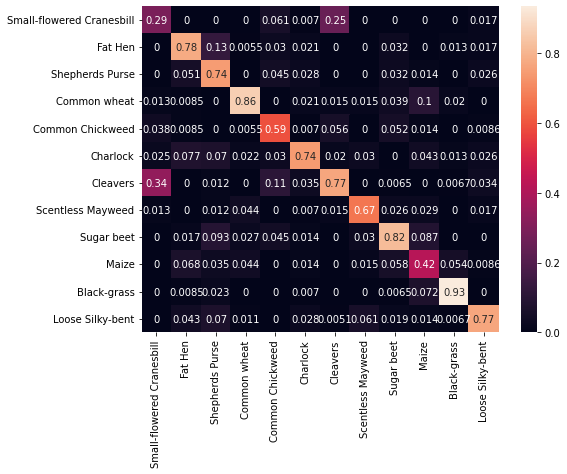

In [62]:
cf_matrix = confusion_matrix(np.array(rounded_labels), y_test_pred_classes_ln1)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

In [63]:
p=precision_recall_fscore_support(np.array(rounded_labels), y_test_pred_classes_ln1, average=None,labels=list(np.unique(rounded_labels)))

print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.40350877 0.73387097 0.62745098 0.84491979 0.65       0.79699248
 0.67873303 0.81481481 0.75147929 0.52727273 0.89102564 0.8317757 ]
 Recall is [0.29113924 0.77777778 0.74418605 0.86338798 0.59090909 0.74125874
 0.76530612 0.66666667 0.81935484 0.42028986 0.93288591 0.76724138] 
 f_beta Score is [0.33823529 0.75518672 0.68085106 0.85405405 0.61904762 0.76811594
 0.71942446 0.73333333 0.78395062 0.46774194 0.91147541 0.79820628]


- Model struggles with Maize, Common Chuickweed and Small-flowered Cranesbill, it is also very accurate in predicting black grass

#### Prediction visualization using model 1

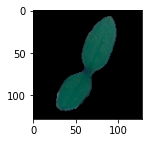

Predicted Label 3
True Label 3


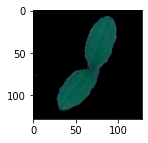

Predicted Label 3
True Label 3


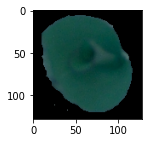

Predicted Label 8
True Label 7


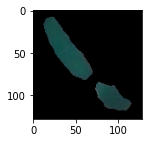

Predicted Label 10
True Label 5


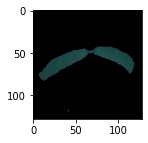

Predicted Label 2
True Label 5


In [64]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[33],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[33].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[33]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[59].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[59]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[36],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[36].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[36]))

### Test prediction using model 2

In [65]:
# Test Prediction 
y_test_pred_ln2 = model2.predict(X_test)
y_test_pred_classes_ln2 = np.argmax(y_test_pred_ln2, axis=1)
y_test_pred_prob_ln2 = np.max(y_test_pred_ln2, axis=1)

In [66]:
# Test Accuracy 
accuracy_score(np.array(rounded_labels), y_test_pred_classes_ln2)

0.8414035087719298

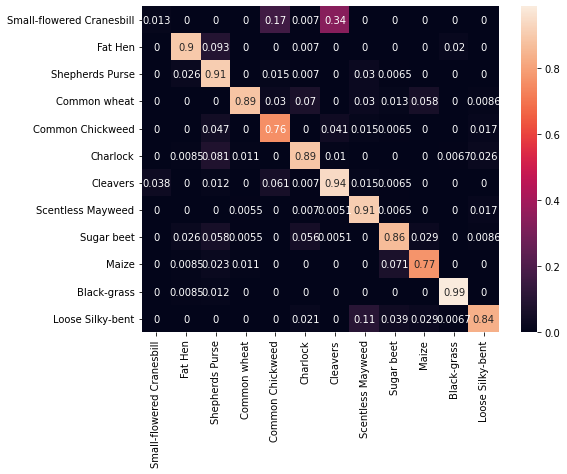

In [67]:
cf_matrix = confusion_matrix(np.array(rounded_labels), y_test_pred_classes_ln2)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)


In [68]:
p=precision_recall_fscore_support(np.array(rounded_labels), y_test_pred_classes_ln2, average=None,labels=list(np.unique(rounded_labels)))

print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.25       0.92105263 0.73584906 0.96428571 0.73529412 0.83006536
 0.70342205 0.82191781 0.85350318 0.86885246 0.96710526 0.91509434]
 Recall is [0.01265823 0.8974359  0.90697674 0.8852459  0.75757576 0.88811189
 0.94387755 0.90909091 0.86451613 0.76811594 0.98657718 0.8362069 ] 
 f_beta Score is [0.02409639 0.90909091 0.8125     0.92307692 0.74626866 0.85810811
 0.80610022 0.86330935 0.85897436 0.81538462 0.97674419 0.87387387]


- Model struggles with predicting Small-flowered Cranesbill, this may be where most of accuracy loss is. Accuracy is higher than model1

#### Prediction Visualization using Model2

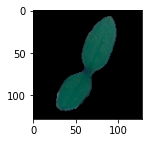

Predicted Label 3
True Label 3


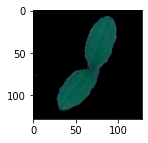

Predicted Label 3
True Label 3


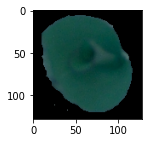

Predicted Label 7
True Label 7


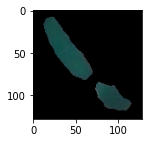

Predicted Label 5
True Label 5


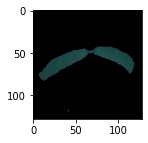

Predicted Label 5
True Label 5


In [69]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model2.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model2.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[33],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model2.predict(X_test[33].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[33]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model2.predict(X_test[59].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[59]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[36],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model2.predict(X_test[36].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[36]))

### Conclusions

- Models actually improved after using HSV which suggests that grayscaling using these images actually caused the models to stop working
- Models could be improved with more convolution and pool layers. 
- Reduced learning rate worked well along with data augmentation to regularize the data and provide a much more accurate model that didn't overfit.
 

